# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
transforms = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']["chessred2k"]['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']["chessred2k"]['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']["chessred2k"]['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:10]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 8
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([8, 224, 224, 3])
tensor([12,  5,  1, 12,  4,  3, 12,  1,  0,  0,  0,  3, 12, 12, 12,  0, 12, 12,
         2, 12, 12,  0, 12, 12, 12, 12, 12, 12,  0,  0, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 10,  6,  9,  9,  6, 12,  6,  6,  6, 12, 12,  6,
        12,  6,  7, 12, 12, 11, 12, 12,  8,  7])
tensor([[12,  5,  1, 12,  4,  3, 12,  1],
        [ 0,  0,  0,  3, 12, 12, 12,  0],
        [12, 12,  2, 12, 12,  0, 12, 12],
        [12, 12, 12, 12,  0,  0, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 10,  6,  9,  9,  6, 12],
        [ 6,  6,  6, 12, 12,  6, 12,  6],
        [ 7, 12, 12, 11, 12, 12,  8,  7]])


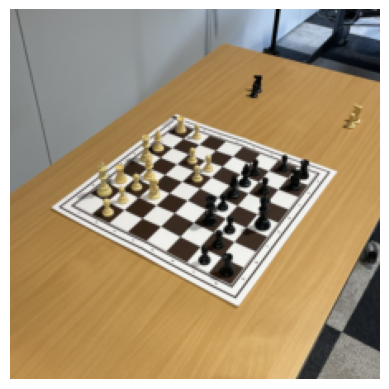

torch.Size([8, 224, 224, 3])
tensor([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0, 12,  0, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  8,  9, 11, 10,  9,  8,  7])
tensor([[ 1,  2,  3,  5,  4,  3,  2,  1],
        [ 0,  0,  0,  0,  0,  0, 12,  0],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12,  0, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [ 6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  8,  9, 11, 10,  9,  8,  7]])


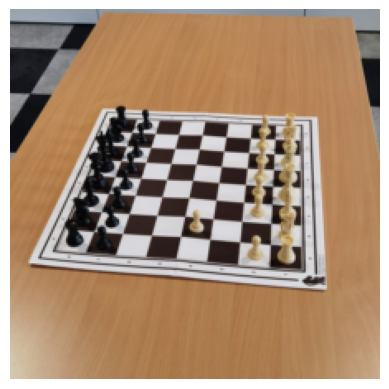

In [8]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[0])
    print(labels[0].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[1])
    print(labels[1].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, 64)
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train the model

Define function to perform one iteration

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 12)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu().detach().numpy())
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
          #print(original_values)
    return total_loss / num_batches, mean_absolute_error(preds, labels)

Define function to train a model

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [12]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 50

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 180/180 [00:11<00:00, 15.89it/s]


Train loss: 2504.49411 	 Train acc: 9.45387


100%|██████████| 42/42 [00:00<00:00, 49.18it/s]


Val loss: 2601.89028 	 Val acc: 9.75648

Epoch 2


100%|██████████| 180/180 [00:10<00:00, 17.86it/s]


Train loss: 2500.03461 	 Train acc: 9.45235


100%|██████████| 42/42 [00:00<00:00, 57.01it/s]


Val loss: 2600.11206 	 Val acc: 9.75880

Epoch 3


100%|██████████| 180/180 [00:10<00:00, 17.77it/s]


Train loss: 2498.74381 	 Train acc: 9.45105


100%|██████████| 42/42 [00:00<00:00, 57.29it/s]


Val loss: 2595.42729 	 Val acc: 9.75871

Epoch 4


100%|██████████| 180/180 [00:10<00:00, 17.71it/s]


Train loss: 2498.60544 	 Train acc: 9.45199


100%|██████████| 42/42 [00:00<00:00, 57.69it/s]


Val loss: 2599.15036 	 Val acc: 9.77099

Epoch 5


100%|██████████| 180/180 [00:10<00:00, 17.76it/s]


Train loss: 2497.21530 	 Train acc: 9.44759


100%|██████████| 42/42 [00:00<00:00, 58.17it/s]


Val loss: 2604.38740 	 Val acc: 9.74964

Epoch 6


100%|██████████| 180/180 [00:10<00:00, 17.79it/s]


Train loss: 2496.14775 	 Train acc: 9.44518


100%|██████████| 42/42 [00:00<00:00, 57.53it/s]


Val loss: 2611.98301 	 Val acc: 9.74114

Epoch 7


100%|██████████| 180/180 [00:09<00:00, 18.01it/s]


Train loss: 2495.20519 	 Train acc: 9.43959


100%|██████████| 42/42 [00:00<00:00, 56.69it/s]


Val loss: 2597.05283 	 Val acc: 9.75590

Epoch 8


100%|██████████| 180/180 [00:09<00:00, 18.03it/s]


Train loss: 2494.40616 	 Train acc: 9.43900


100%|██████████| 42/42 [00:00<00:00, 55.35it/s]


Val loss: 2598.30294 	 Val acc: 9.75824

Epoch 9


100%|██████████| 180/180 [00:10<00:00, 17.38it/s]


Train loss: 2492.29622 	 Train acc: 9.43237


100%|██████████| 42/42 [00:00<00:00, 53.93it/s]


Val loss: 2600.60160 	 Val acc: 9.74173

Epoch 10


100%|██████████| 180/180 [00:10<00:00, 17.83it/s]


Train loss: 2492.54835 	 Train acc: 9.43285


100%|██████████| 42/42 [00:00<00:00, 55.28it/s]


Val loss: 2597.46016 	 Val acc: 9.74779

Epoch 11


100%|██████████| 180/180 [00:10<00:00, 17.89it/s]


Train loss: 2490.03550 	 Train acc: 9.42806


100%|██████████| 42/42 [00:00<00:00, 55.55it/s]


Val loss: 2599.70921 	 Val acc: 9.73609

Epoch 12


100%|██████████| 180/180 [00:10<00:00, 17.93it/s]


Train loss: 2490.49374 	 Train acc: 9.42826


100%|██████████| 42/42 [00:00<00:00, 55.90it/s]


Val loss: 2611.93677 	 Val acc: 9.73642

Epoch 13


100%|██████████| 180/180 [00:10<00:00, 17.85it/s]


Train loss: 2488.74640 	 Train acc: 9.42553


100%|██████████| 42/42 [00:00<00:00, 57.53it/s]


Val loss: 2602.16567 	 Val acc: 9.73587

Epoch 14


100%|██████████| 180/180 [00:10<00:00, 17.98it/s]


Train loss: 2487.42171 	 Train acc: 9.42486


100%|██████████| 42/42 [00:00<00:00, 58.54it/s]


Val loss: 2602.73613 	 Val acc: 9.74246

Epoch 15


100%|██████████| 180/180 [00:10<00:00, 17.78it/s]


Train loss: 2485.95904 	 Train acc: 9.42413


100%|██████████| 42/42 [00:00<00:00, 57.53it/s]


Val loss: 2618.40360 	 Val acc: 9.71565

Epoch 16


100%|██████████| 180/180 [00:10<00:00, 17.91it/s]


Train loss: 2485.17253 	 Train acc: 9.42225


100%|██████████| 42/42 [00:00<00:00, 56.44it/s]


Val loss: 2611.70371 	 Val acc: 9.75242

Epoch 17


100%|██████████| 180/180 [00:10<00:00, 17.77it/s]


Train loss: 2483.28787 	 Train acc: 9.42037


100%|██████████| 42/42 [00:00<00:00, 58.33it/s]


Val loss: 2607.24190 	 Val acc: 9.74988

Epoch 18


100%|██████████| 180/180 [00:10<00:00, 17.98it/s]


Train loss: 2482.00449 	 Train acc: 9.42013


100%|██████████| 42/42 [00:00<00:00, 58.50it/s]


Val loss: 2607.84962 	 Val acc: 9.74861

Epoch 19


100%|██████████| 180/180 [00:10<00:00, 17.95it/s]


Train loss: 2480.76329 	 Train acc: 9.42130


100%|██████████| 42/42 [00:00<00:00, 55.62it/s]


Val loss: 2610.71836 	 Val acc: 9.74520

Epoch 20


100%|██████████| 180/180 [00:09<00:00, 18.01it/s]


Train loss: 2480.76305 	 Train acc: 9.42167


100%|██████████| 42/42 [00:00<00:00, 55.44it/s]


Val loss: 2612.00561 	 Val acc: 9.73885

Epoch 21


100%|██████████| 180/180 [00:10<00:00, 17.88it/s]


Train loss: 2479.32692 	 Train acc: 9.42207


100%|██████████| 42/42 [00:00<00:00, 53.94it/s]


Val loss: 2605.62613 	 Val acc: 9.74591

Epoch 22


100%|██████████| 180/180 [00:09<00:00, 18.19it/s]


Train loss: 2476.44907 	 Train acc: 9.41857


100%|██████████| 42/42 [00:00<00:00, 61.86it/s]


Val loss: 2610.69947 	 Val acc: 9.74345

Epoch 23


100%|██████████| 180/180 [00:09<00:00, 19.72it/s]


Train loss: 2474.46545 	 Train acc: 9.41608


100%|██████████| 42/42 [00:00<00:00, 60.17it/s]


Val loss: 2616.26761 	 Val acc: 9.75181

Epoch 24


100%|██████████| 180/180 [00:09<00:00, 19.71it/s]


Train loss: 2473.04043 	 Train acc: 9.41658


100%|██████████| 42/42 [00:00<00:00, 61.49it/s]


Val loss: 2627.96286 	 Val acc: 9.73725

Epoch 25


100%|██████████| 180/180 [00:09<00:00, 19.69it/s]


Train loss: 2471.25295 	 Train acc: 9.41534


100%|██████████| 42/42 [00:00<00:00, 61.06it/s]


Val loss: 2624.37176 	 Val acc: 9.74191

Epoch 26


100%|██████████| 180/180 [00:09<00:00, 19.66it/s]


Train loss: 2470.19070 	 Train acc: 9.41332


100%|██████████| 42/42 [00:00<00:00, 61.44it/s]


Val loss: 2617.50550 	 Val acc: 9.75817

Epoch 27


100%|██████████| 180/180 [00:09<00:00, 19.62it/s]


Train loss: 2468.82538 	 Train acc: 9.41414


100%|██████████| 42/42 [00:00<00:00, 57.58it/s]


Val loss: 2622.12945 	 Val acc: 9.75637

Epoch 28


100%|██████████| 180/180 [00:09<00:00, 19.22it/s]


Train loss: 2467.86616 	 Train acc: 9.41504


100%|██████████| 42/42 [00:00<00:00, 61.05it/s]


Val loss: 2613.39504 	 Val acc: 9.74722

Epoch 29


100%|██████████| 180/180 [00:10<00:00, 17.38it/s]


Train loss: 2464.85659 	 Train acc: 9.41060


100%|██████████| 42/42 [00:00<00:00, 55.78it/s]


Val loss: 2620.58934 	 Val acc: 9.75373

Epoch 30


100%|██████████| 180/180 [00:10<00:00, 17.90it/s]


Train loss: 2462.10262 	 Train acc: 9.40932


100%|██████████| 42/42 [00:00<00:00, 57.23it/s]


Val loss: 2615.66546 	 Val acc: 9.75206

Epoch 31


100%|██████████| 180/180 [00:10<00:00, 17.74it/s]


Train loss: 2461.10637 	 Train acc: 9.40866


100%|██████████| 42/42 [00:00<00:00, 57.48it/s]


Val loss: 2631.17476 	 Val acc: 9.74472

Epoch 32


100%|██████████| 180/180 [00:10<00:00, 17.66it/s]


Train loss: 2462.15186 	 Train acc: 9.41401


100%|██████████| 42/42 [00:00<00:00, 53.85it/s]


Val loss: 2624.82806 	 Val acc: 9.75169

Epoch 33


100%|██████████| 180/180 [00:10<00:00, 16.81it/s]


Train loss: 2461.42438 	 Train acc: 9.41473


100%|██████████| 42/42 [00:00<00:00, 53.38it/s]


Val loss: 2619.70810 	 Val acc: 9.75174

Epoch 34


100%|██████████| 180/180 [00:10<00:00, 16.56it/s]


Train loss: 2461.11783 	 Train acc: 9.41956


100%|██████████| 42/42 [00:00<00:00, 49.86it/s]


Val loss: 2622.45754 	 Val acc: 9.75748

Epoch 35


100%|██████████| 180/180 [00:10<00:00, 17.49it/s]


Train loss: 2458.27696 	 Train acc: 9.41645


100%|██████████| 42/42 [00:00<00:00, 54.82it/s]


Val loss: 2622.64257 	 Val acc: 9.76044

Epoch 36


100%|██████████| 180/180 [00:10<00:00, 17.79it/s]


Train loss: 2458.62312 	 Train acc: 9.42056


100%|██████████| 42/42 [00:00<00:00, 57.98it/s]


Val loss: 2626.29893 	 Val acc: 9.76561

Epoch 37


100%|██████████| 180/180 [00:10<00:00, 17.96it/s]


Train loss: 2457.69107 	 Train acc: 9.42622


100%|██████████| 42/42 [00:00<00:00, 55.77it/s]


Val loss: 2631.81605 	 Val acc: 9.75725

Epoch 38


100%|██████████| 180/180 [00:09<00:00, 18.09it/s]


Train loss: 2456.17561 	 Train acc: 9.42625


100%|██████████| 42/42 [00:00<00:00, 58.33it/s]


Val loss: 2629.10888 	 Val acc: 9.76761

Epoch 39


100%|██████████| 180/180 [00:10<00:00, 17.73it/s]


Train loss: 2454.71471 	 Train acc: 9.42731


100%|██████████| 42/42 [00:00<00:00, 56.07it/s]


Val loss: 2630.51210 	 Val acc: 9.76777

Epoch 40


100%|██████████| 180/180 [00:10<00:00, 17.26it/s]


Train loss: 2455.23716 	 Train acc: 9.43130


100%|██████████| 42/42 [00:00<00:00, 58.24it/s]


Val loss: 2627.45183 	 Val acc: 9.76325

Epoch 41


100%|██████████| 180/180 [00:09<00:00, 18.01it/s]


Train loss: 2455.19663 	 Train acc: 9.43272


100%|██████████| 42/42 [00:00<00:00, 57.45it/s]


Val loss: 2627.46494 	 Val acc: 9.77510

Epoch 42


100%|██████████| 180/180 [00:10<00:00, 17.88it/s]


Train loss: 2453.31613 	 Train acc: 9.43668


100%|██████████| 42/42 [00:00<00:00, 54.89it/s]


Val loss: 2626.58087 	 Val acc: 9.77428

Epoch 43


100%|██████████| 180/180 [00:10<00:00, 17.89it/s]


Train loss: 2452.74616 	 Train acc: 9.44150


100%|██████████| 42/42 [00:00<00:00, 54.89it/s]


Val loss: 2634.68020 	 Val acc: 9.77104

Epoch 44


100%|██████████| 180/180 [00:10<00:00, 17.98it/s]


Train loss: 2451.37434 	 Train acc: 9.44096


100%|██████████| 42/42 [00:00<00:00, 55.42it/s]


Val loss: 2632.33591 	 Val acc: 9.78305

Epoch 45


100%|██████████| 180/180 [00:10<00:00, 17.72it/s]


Train loss: 2451.55892 	 Train acc: 9.44493


100%|██████████| 42/42 [00:00<00:00, 54.43it/s]


Val loss: 2630.19004 	 Val acc: 9.78574

Epoch 46


100%|██████████| 180/180 [00:10<00:00, 17.93it/s]


Train loss: 2452.37660 	 Train acc: 9.44974


100%|██████████| 42/42 [00:00<00:00, 55.77it/s]


Val loss: 2633.87762 	 Val acc: 9.79360

Epoch 47


100%|██████████| 180/180 [00:10<00:00, 17.95it/s]


Train loss: 2450.57165 	 Train acc: 9.45227


100%|██████████| 42/42 [00:00<00:00, 57.03it/s]


Val loss: 2633.87977 	 Val acc: 9.78914

Epoch 48


100%|██████████| 180/180 [00:10<00:00, 17.68it/s]


Train loss: 2450.12662 	 Train acc: 9.45715


100%|██████████| 42/42 [00:00<00:00, 56.41it/s]


Val loss: 2636.73856 	 Val acc: 9.78657

Epoch 49


100%|██████████| 180/180 [00:10<00:00, 17.83it/s]


Train loss: 2450.82486 	 Train acc: 9.46319


100%|██████████| 42/42 [00:00<00:00, 58.29it/s]


Val loss: 2639.17843 	 Val acc: 9.78668

Epoch 50


100%|██████████| 180/180 [00:10<00:00, 17.95it/s]


Train loss: 2450.25252 	 Train acc: 9.46706


100%|██████████| 42/42 [00:00<00:00, 57.86it/s]


Val loss: 2636.80863 	 Val acc: 9.78790
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [16]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

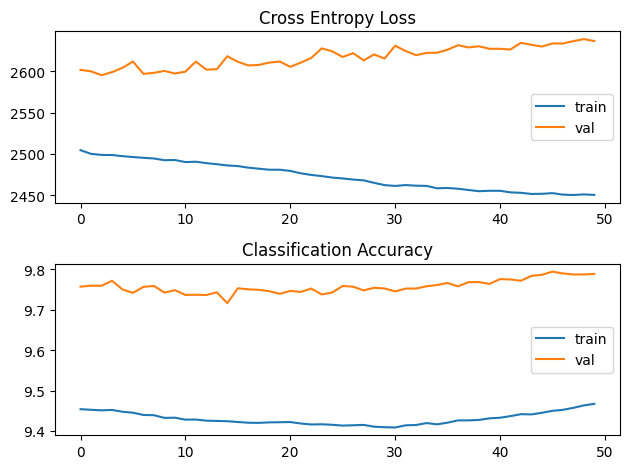

In [17]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [18]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*32
        preds.extend(predsTmp)
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu()
        labels.extend(original_values)
        #print(original_values)
    return mean_absolute_error(preds, labels)
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

100%|██████████| 39/39 [00:00<00:00, 39.68it/s]

Test loss: 9.637


## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?